来自知乎的笔记
https://zhuanlan.zhihu.com/p/60023855

1，数据准备

In [18]:
import matplotlib.pyplot as plt
import pandas as pd
import datetime

def generate_purchase_seq():
  dateparse = lambda dates : datetime.datetime.strptime(dates, '%Y%m%d')
  user_balance = pd.read_csv('user_balance_table.csv', parse_dates=['report_date'], index_col='report_date', date_parser=dateparse)
  df = user_balance.groupby(['report_date'])['total_purchase_amt'].sum()

  purchase_seq = pd.Series(df, name='value')
  purchase_seq_201402_201407 = purchase_seq['2014-02-01':'2014-07-31']
  purchase_seq_201402_201407.to_csv('purchase_seq_201402_201407.csv', header=True)

In [17]:
generate_purchase_seq()

2，相关术语

In [20]:
def purchase_seq_display(timeseries):
  graph = plt.figure(figsize=(10,4))
  ax = graph.add_subplot(111)
  ax.set(title='Total_Purchase_Amt', ylabel = 'Unit (yuan)', xlabel='Date')
  plt.plot(timeseries)
  plt.show()

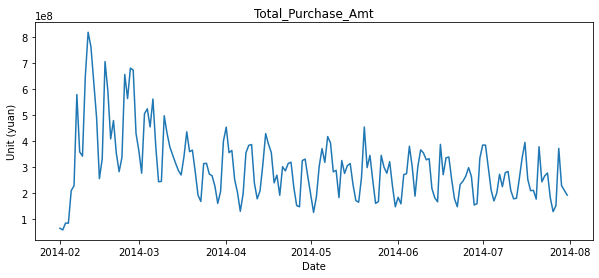

In [24]:
dateparse = lambda dates: datetime.datetime.strptime(dates, '%Y-%m-%d')
purchase_seq_201402_201407 = pd.read_csv('purchase_seq_201402_201407.csv', parse_dates=['report_date'], index_col='report_date', date_parser=dateparse)
purchase_seq_display(purchase_seq_201402_201407)

**趋势：**  
趋势是时间序列在某一方向上的持续运动， 现象是较长时间内受到某种根本性因素作用而形成的总的变化趋势。上图中可以看到，余额宝的申购资金一路下降，这是一个明显的趋势。  
**季节变化：**  
许多的时间序列中包含季节变化，现象是在一年内随着季节的变化而发生的有规律的周期性变动。
上图中肉眼很难看到时间序列随季节变化。  
**序列相关性：**  
又称”自相关性。
上图中可以看到， 数据之间存在一定的正相关和负相关。
自相关是时间序列可以预测未来的前提。如果没有自相关，就变成了白噪声（无规律）。  
**随机噪声**  
他是时间序列中除去趋势，季节变化和自相关后的剩余随机扰动。
由于时间序列存在不确定性，随机噪声总是夹杂在时间序列中，致使时间序列表现出某种震荡式的无规律运动。


3，时间序列分解

In [25]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [28]:
def decomposing(timeseries):
  decomposition = seasonal_decompose(timeseries)
  trend = decomposition.trend
  seasonal = decomposition.seasonal
  residual = decomposition.resid

  plt.figure(figsize=(16,21))
  plt.subplot(411)
  plt.plot(timeseries, label='Original')
  plt.legend(loc='best')
  plt.subplot(412)
  plt.plot(trend, label='Trend')
  plt.legend(loc='best')
  plt.subplot(413)
  plt.plot(seasonal, label='Seasonarity')
  plt.legend(loc='best')
  plt.subplot(414)
  plt.plot(residual, label='Residual')
  plt.legend(loc='best')
  plt.show()

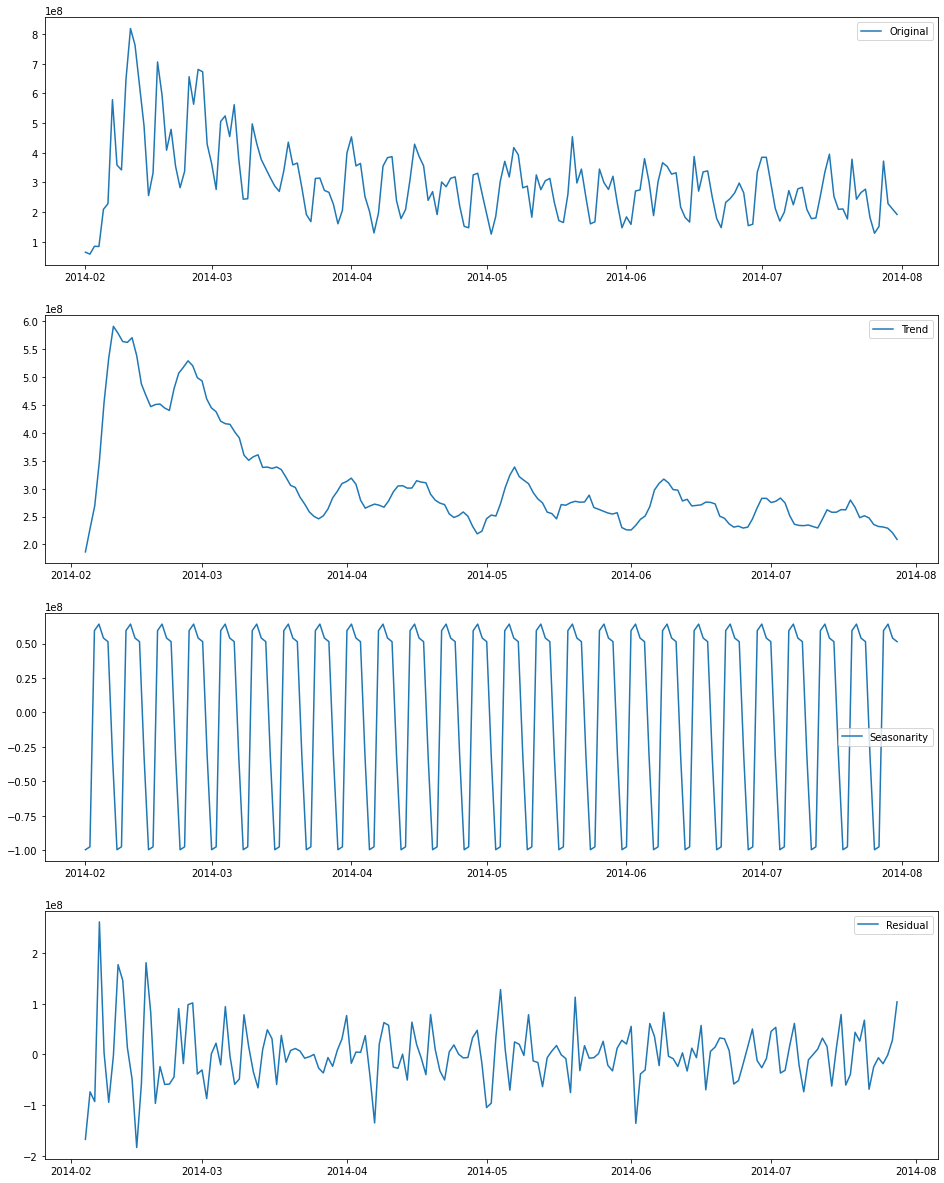

In [29]:
dateparse = lambda dates: datetime.datetime.strptime(dates, '%Y-%m-%d')
purchase_seq_201402_201407 = pd.read_csv('purchase_seq_201402_201407.csv', parse_dates=['report_date'], index_col='report_date', date_parser=dateparse)
decomposing(purchase_seq_201402_201407)

4，时间序列的平稳性  
**平稳性定义：**  
 - 均值u与时间t无关的常数
 - 对于任意时刻t和任意时间间隔k，时间序列$z_t$与$z_{t-k}$的自协方差$r_k$只与k有关，与t无关

从统计学来讲，平稳性的要求就是对于一个时间序列（未知分布），这个时间序列的取值一定满足一个确定的分布。

平稳性对于分析时间序列特别重要。如果一个序列不是平稳的，通常需要通过差分的方式将其转化为平稳时间序列。

对于一个时间序列，如何确定它是否满足平稳性要求？
**通常采用ADF检验。**

**离散白噪声**  
$X_t$ = $w_t$  
$w_t$~(0,$\sigma^2$) AND  自相关系数$\rho_k$均为0

**随机游走**  
$X_t$ = $X_{t-1}$ + $w_t$  
$w_t$白噪声  
则$X_t$为随机游走：$X_t$~(0,t$\sigma^2$)

显然，白噪声他满足正态分布，均值与方差均与时间无关，满足平稳性要求。
对于随机游走，他均值为0，方差与时间有关，他不满足平稳性要求。

**ADF大致的思想就是基于随机游走的**
对于$X_t$回归，如果发现p=1,说明序列满足随机游走，就是非平稳的。
 - $X_t = X_{t-1}+ u_t$ 随机游走，非平稳
 - $X_t = pX_{t-1}+ u_t$ 对待估计的时间序列回归，如果发现$p=1$,则称$X_t$有一个单位根。

通过上式判断$X_t$是否具有单位根，来确定是否平稳。

我们将生成的文件进行一阶差分和二阶差分，并分别计算他们的ADF值。


In [30]:
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller as ADF

In [31]:
def diff(timeseries):
  timeseries_diff1 = timeseries.diff(1)
  timeseries_diff2 = timeseries_diff1.diff(1)

  timeseries_diff1 = timeseries_diff1.fillna(0)
  timeseries_diff2 = timeseries_diff2.fillna(0)

  timeseries_adf = ADF(timeseries['value'].tolist())
  timeseries_diff1_adf = ADF(timeseries_diff1['value'].tolist())
  timeseries_diff2_adf = ADF(timeseries_diff2['value'].tolist())
  
  print('timeseries_adf: ', timeseries_adf)
  print('timeseries_diff1_adf: ', timeseries_diff1_adf)
  print('timeseries_diff2_adf: ', timeseries_diff2_adf)

  plt.figure(figsize=(16,12))
  plt.plot(timeseries, label='Original', color='blue')
  plt.plot(timeseries_diff1, label='Diff1', color='red')
  plt.plot(timeseries_diff2, label='Diff2', color='purple')
  plt.legend(loc='best')
  plt.show()

timeseries_adf:  (-1.7428122115771916, 0.4092001716091841, 13, 167, {'1%': -3.470126426071447, '5%': -2.8790075987120027, '10%': -2.5760826967621644}, 6462.731450458982)
timeseries_diff1_adf:  (-10.061094335038446, 1.3329276481740765e-17, 12, 168, {'1%': -3.4698858990744115, '5%': -2.8789026251889647, '10%': -2.5760266680839004}, 6463.521915345894)
timeseries_diff2_adf:  (-8.369488957177847, 2.686267936267515e-13, 14, 166, {'1%': -3.4703698981001665, '5%': -2.8791138497902193, '10%': -2.576139407751488}, 6490.52295323287)


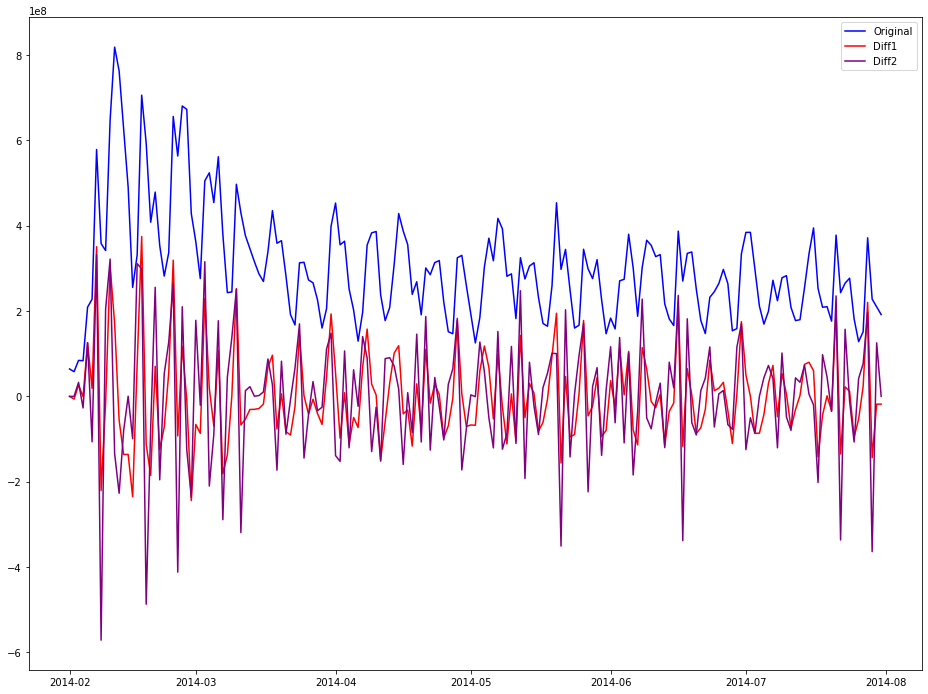

In [32]:
dateparse = lambda dates: datetime.datetime.strptime(dates, '%Y-%m-%d')
purchase_seq_201402_201407 = pd.read_csv('purchase_seq_201402_201407.csv', parse_dates=['report_date'], index_col='report_date', date_parser=dateparse)
diff(purchase_seq_201402_201407)

从上图可以看出，经过一阶差分，元序列的趋势被消除了，整个序列基本围绕确定的均值震荡。经过二阶差分，与一阶差分相比，只是震荡幅度上扩大了，因此对于该序列，采用一阶差分比较合适。
**一般情况下，采用一阶，二阶差分就可以使序列变得平稳**

再来看一下ADF计算的结果，首先介绍下各个主要参数的含义。  
第一个参数：T检验，假设检验值  
第二个参数：P-Value, 假设检验结果  
第五个参数：不同程度拒绝原假设的统计值。  

如何确定该序列是否平稳呢？
 - 1%，5%，10%不同程度拒绝原假设的统计值和ADF假设检验值比较，ADF假设检验值同时小于1%，5%，10%即说明非常好的拒绝该假设。
 - P-Value是否非常接近0

ADF检验的原假设是存在单位根（不平稳），只要这个统计值是小于1%水平以下的数字就可以极显著的拒绝原假设，认为数据平稳。
对于ADF值在1%～5%之间，也不能说不平稳，关键看检验要求是什麽样子。

5，自相关系数（ACF)，偏相关系数（PACF)  
首先，介绍一下协方差：  
Cov(X,Y) = $E[(X-{\mu}x)]E[(Y-{\mu}y)]$  
在实际中由于总体的分布未知，我们只能通过X,Y的观测值来计算样本均值。  
样本协方差：  
$$\frac{1}{n-1}\sum_{i=1}^n(X_i-\tilde{X})(Y_i-\tilde{Y})$$

**然而，用协方差来衡量变量之间的相关性是有问题的：协方差使用量纲的，因此它的大小受随机变量本身波动范围的影响。最简单的做法就是用变量自身的波动对协方差进行标准化。相关系数便由此而来。**  

另$\rho$表示X,Y的总体相关系数，他的定义为：
$$\rho(X,Y) = \frac{Cov(X,Y)}{\sigma_X\sigma_Y}$$
其中$\sigma_X$和$\sigma_Y$分别是X和Y的总体标准差。
通过使用X和Y的标准差对他们的协方差归一化，$\rho$的取值范围[-1,1]:
 - $\rho$=1表示X,Y之间存在确切的线性正相关
 - $\rho$=0表示X,Y之间不存在任何的线性相关性
 - $\rho$=-1表示X,Y之间存在确切的线性负相关

时间序列的特点是一维的，因此如果用上面的指标衡量有点不太适宜。
根据时间序列的特点，形成了自相关函数，偏自相关函数。
前面的“自”原因是时间序列没有办法再找到一个别的数据来跟自己进行比较，只能自己和自己比较，自己和自己慢几拍（滞后期）的这些数据进行比较，所以加了一个“自”。



**自相关系数**  
自相关系数度量的是同一事件在两个不同时期之间的相关程度，形象的讲就是度量自己过去的行为对自己现在的影响。
$$ACF(k) = \sum_{t=k+1}^n\frac{(Z_t - \tilde{Z})(Z_{t-k} - \tilde{Z})}{\sum_{t=1}^n(Z_t - \tilde{Z})^2}$$

自相关（autocorrelation），也叫序列相关，是一个信号其自身在不同时间点的相关度。
非正式的来说，他就是两次观察之间的相似度对他们之间的时间差的函数。他是找出重复模式（如被噪声掩盖的周期信号）或识别哟隐含在信号谐波频率中消失的基频的数学工具。他常用于信号处理中，用来分析函数或一系列值，如时域信号。

偏自相关系数（PACF），根据ACF求出滞后ｋ自相关系数ACF(k)时，实际上得到的并不是Z(t)与Z(t-k)之间单纯的相关关系。
应为Z(t)同时还要受到中间ｋ－１个随机变量的影响，而这ｋ－１个变量有都和Z(t-k)具有相关关系，所以自相关系数里实际掺杂了其他变量对Z(t)与Z(t-k)的影响。

为了能单纯测度Z(t-k)对Z(t)的影响，引进了偏自相关系数的概念。
对于平稳时间序列，所谓滞后ｋ偏自相关系数指在给定中间ｋ－１个随机变量的条件下，或者说，在剔除了中间ｋ－１个随机变量的干扰后，Z(t-k)对Z(t)影响的相关程度：
$$PACF(k)=\frac{Cov[(Z_t-\tilde{Z_t}),(Z_{t-k}-\tilde{Z_{t-k}})]}{\sqrt{var(Z_t-\tilde{Z_t})}\sqrt{var(Z_{t-k}-\tilde{Z_{t-k}})}}$$

计算某一个要素对另一个要素的影响或相关程度时，把其他要素的影响视为常数，既暂不考虑其他要素的影响，而单独研究那两个要素之间的相互关系的密切程度时，称为偏相关。

根据第4小节关于平稳性的讨论，为了防止“虚假回归”，需要对文件进行一阶差分后，在讨论序列的自相关性。

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller as ADF
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

In [37]:
def autocorrelation(timeseries, lags):
  fig =  plt.figure(figsize=(12,8))
  ax1 = fig.add_subplot(211)
  sm.graphics.tsa.plot_acf(timeseries, lags=lags, ax=ax1)
  ax2 = fig.add_subplot(212)
  sm.graphics.tsa.plot_pacf(timeseries, lags=lags, ax=ax2)
  plt.show()

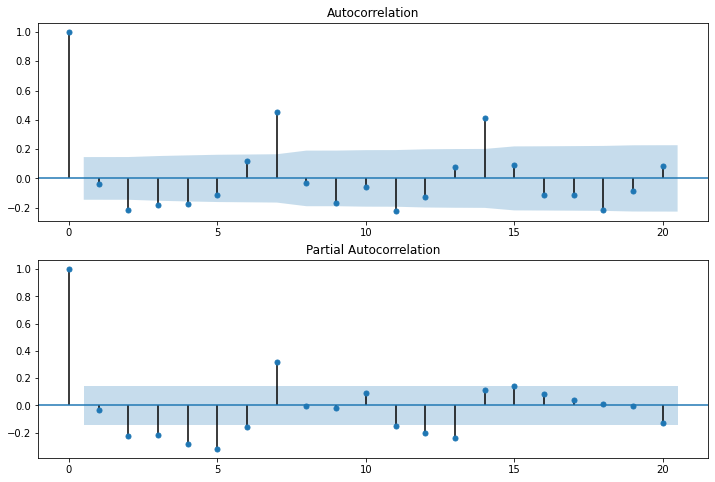

In [38]:
dateparse = lambda dates: datetime.datetime.strptime(dates, '%Y-%m-%d')
purchase_seq_201402_201407 = pd.read_csv('purchase_seq_201402_201407.csv', parse_dates=['report_date'], index_col='report_date', date_parser=dateparse)
purchase_seq_201402_201407_diff1 = purchase_seq_201402_201407.diff(1)
purchase_seq_201402_201407_diff1 = purchase_seq_201402_201407_diff1.fillna(0)
autocorrelation(purchase_seq_201402_201407_diff1, 20)

对时间序列进行建模最重要的就是挖掘出该序列中不同间隔k的自相关性。
相关图可以帮助我们判断模型是否合适。这是因为时间序列的特征中往往包括相关性和随机噪声。如果模型很好的捕捉到了自相关性，那么原始时间序列与模型拟合的时间序列之间的残差应该近似的等于随机噪声。残差序列自然也是一个时间序列，因此可以对他画出相关图。一个标准随机噪声的自相关满足$\rho_0 = 1$以及$\rho_k=0$，即对于任意不为0的间隔，随机噪声的自相关均为0